<a href="https://colab.research.google.com/github/iniparhan/Bone_Fracture_Detection/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer

import opendatasets as od

import warnings
warnings.filterwarnings('ignore')
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pathlib import Path


print("\n Library Done!! \n")


 Library Done!! 



- Login ke akun Kaggle: https://www.kaggle.com

- Klik foto profil (pojok kanan atas) → Account

- Scroll ke bawah ke bagian API → klik Create New API Token

- File kaggle.json akan otomatis terunduh.

In [2]:
dataset_url = 'https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahmadfarhanqf
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data


100%|██████████| 481M/481M [00:01<00:00, 264MB/s]


In [3]:
# Define the paths to the datasets
data_dir = '/content/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification'
train_dir = os.path.join(data_dir,  'train')
test_dir = os.path.join(data_dir,  'test')
val_dir = os.path.join(data_dir,  'val')

In [4]:
SIZE = 32
HEIGHT = 180
WIDTH = 180

In [5]:
train_dataset = image_dataset_from_directory(train_dir, image_size=(HEIGHT, WIDTH), batch_size=SIZE)

test_dataset = image_dataset_from_directory(test_dir, image_size=(HEIGHT, WIDTH), batch_size=SIZE)

val_dataset = image_dataset_from_directory(val_dir, image_size=(HEIGHT, WIDTH), batch_size=SIZE)

Found 9246 files belonging to 2 classes.
Found 506 files belonging to 2 classes.
Found 829 files belonging to 2 classes.


In [6]:
class_names = train_dataset.class_names
class_names

['fractured', 'not fractured']

In [12]:
def show_images_from_dataset_folder(dataset_dir=None, total_per_class=5, title='Sample Images'):
    if dataset_dir == None:
        return "Tidak Ada Dataset Yang Diberikan"
    else:
        class_folders = sorted(os.listdir(dataset_dir))
        all_image_paths = []
        all_labels = []

        for class_name in class_folders:
            class_path = os.path.join(dataset_dir, class_name)
            if not os.path.isdir(class_path):
                continue

            all_files = os.listdir(class_path)

            sample_files = all_files[:total_per_class] if len(all_files) < total_per_class else \
                           np.random.choice(all_files, total_per_class, replace=False)

            image_paths = [os.path.join(class_path, fname) for fname in sample_files]
            all_image_paths.extend(image_paths)
            all_labels.extend([class_name] * len(image_paths))

        total_classes = len(class_folders)
        total_images = len(all_image_paths)

        plt.figure(figsize=(3 * total_per_class, 3 * total_classes))
        for i, (path, label) in enumerate(zip(all_image_paths, all_labels)):
            plt.subplot(total_classes, total_per_class, i + 1)
            img = Image.open(path).convert('RGB')
            plt.imshow(img)
            plt.title(label, fontsize=9)
            plt.axis('off')

        plt.suptitle(title, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()



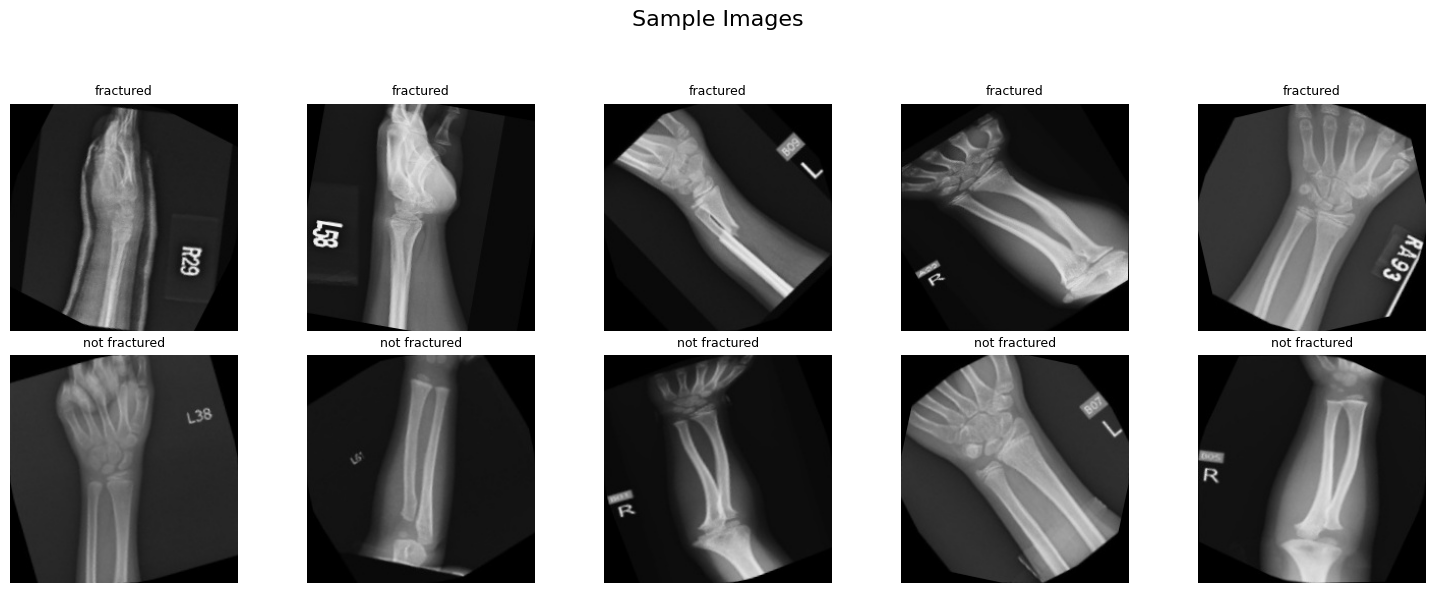

In [13]:
show_images_from_dataset_folder(dataset_dir=train_dir, total_per_class=5, title='Sample Images')

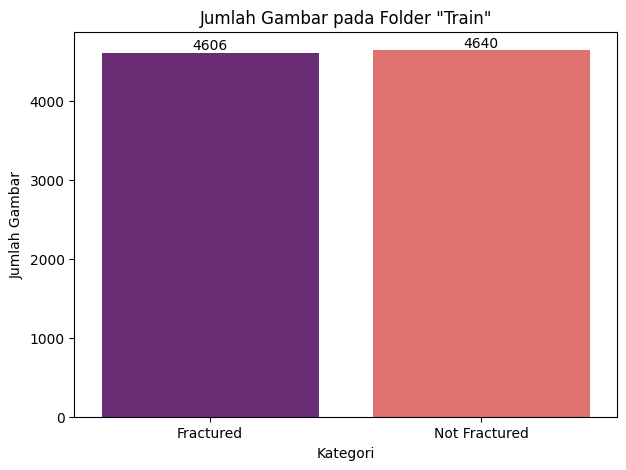

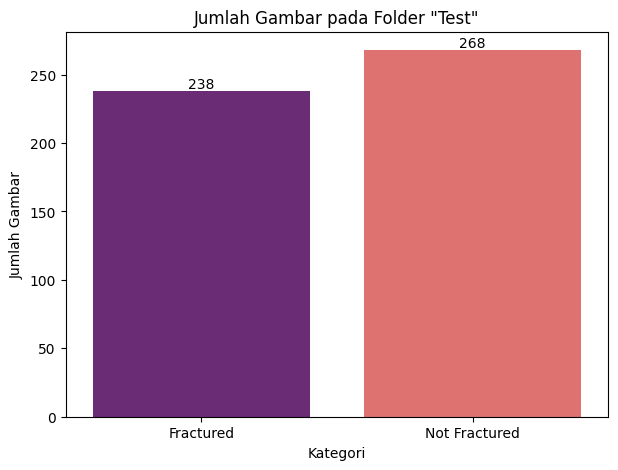

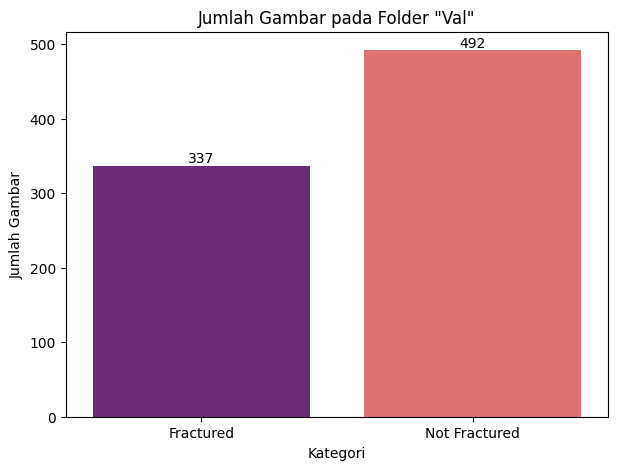

In [14]:
list_data_dir = [train_dir, test_dir, val_dir]
data_type = ['Train', 'Test', 'Val']

for idx, data in enumerate(list_data_dir):
    data_recent_fractured = os.path.join(data, class_names[0])
    len_data_recent_fractured = len(os.listdir(data_recent_fractured))

    data_recent_not_fractured = os.path.join(data, class_names[1])
    len_data_recent_not_fractured = len(os.listdir(data_recent_not_fractured))

    plt.figure(figsize=(7, 5))
    ax = sns.barplot(x=['Fractured', 'Not Fractured'], y=[len_data_recent_fractured, len_data_recent_not_fractured], palette='magma')

    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(f'{count}',              # teks label
                    (p.get_x() + p.get_width() / 2, count),  # posisi
                    ha='center', va='bottom', fontsize=10, fontweight=None)

    plt.title(f'Jumlah Gambar pada Folder "{data_type[idx]}"')
    plt.xlabel('Kategori')
    plt.ylabel('Jumlah Gambar')
    plt.show()

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(HEIGHT, WIDTH),
                                                 batch_size=SIZE,
                                                 class_mode='binary')

test_set = train_datagen.flow_from_directory(test_dir,
                                             target_size=(HEIGHT, WIDTH),
                                             batch_size=SIZE,
                                             class_mode='binary')

val_set = train_datagen.flow_from_directory(val_dir,
                                            target_size=(HEIGHT, WIDTH),
                                            batch_size=SIZE,
                                            class_mode='binary')

Found 9246 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Found 829 images belonging to 2 classes.


In [17]:
model = Sequential([
    InputLayer(input_shape=(HEIGHT, WIDTH, 3)),
    Conv2D(32, (3, 3), activation='relu'),

    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),

    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),

    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,647,105 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
history = model.fit(training_set,
                   validation_data=test_set,
                   epochs=10
                   )

Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 667s 2s/step - accuracy: 0.6625 - loss: 0.6157 - val_accuracy: 0.8241 - val_loss: 0.4167
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - accuracy: 0.8759 - loss: 0.2967 - val_accuracy: 0.8775 - val_loss: 0.3043
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 649s 2s/step - accuracy: 0.9389 - loss: 0.1682 - val_accuracy: 0.9150 - val_loss: 0.2234
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 653s 2s/step - accuracy: 0.9569 - loss: 0.1201 - val_accuracy: 0.9071 - val_loss: 0.2529
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 653s 2s/step - accuracy: 0.9671 - loss: 0.1032 - val_accuracy: 0.9447 - val_loss: 0.1445
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - accuracy: 0.9736 - loss: 0.0766 - val_accuracy: 0.9447 - val_loss: 0.1534
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.9830 - loss: 0.0488 - val_accuracy: 0.9644 - val_loss: 0.1056
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 646s 2s/step - accuracy: 0.9867 - loss: 0.0428 - val_accu

In [20]:
def plot(hist):
  history = hist.history
  history['epoch'] = hist.epoch

  plt.figure(figsize=(12, 5))

  plt.subplot(121)
  plt.plot(history['epoch'], history['loss'], label='Loss')
  plt.plot(history['epoch'], history['val_loss'], label='Val Loss', color='orange')
  plt.legend()

  plt.subplot(122)
  plt.plot(history['epoch'], history['accuracy'], label='Acc')
  plt.plot(history['epoch'], history['val_accuracy'], label='Val Acc', color='orange')
  plt.legend()

  return plt.show()

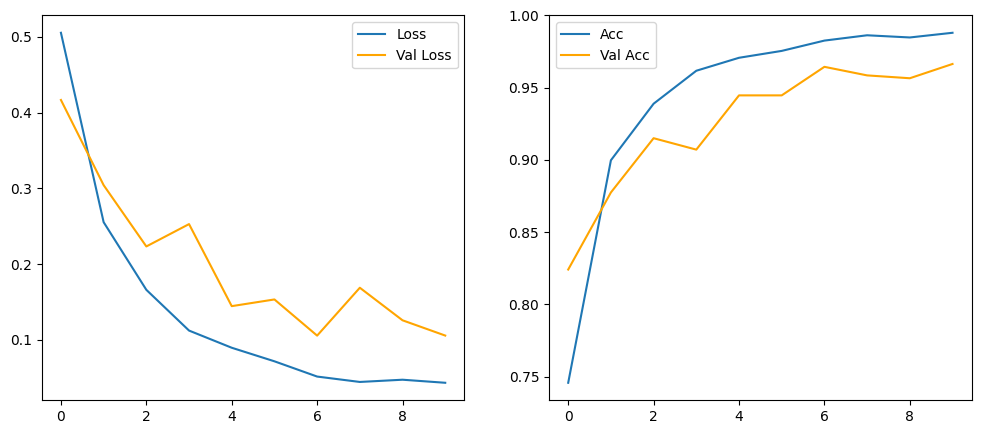

In [21]:
plot(history)

In [22]:
model.save('bone_fracture_model.h5')

In [23]:
loaded_model = tf.keras.models.load_model('bone_fracture_model.h5')

In [24]:
def load_preprocessed_image(image_path, HEIGHT=180, WIDTH=180):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((HEIGHT, WIDTH))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

image_path = os.path.join(train_dir, 'not fractured/2.png')
preprocessed_img = load_preprocessed_image(image_path)

In [25]:
predictions = loaded_model.predict(preprocessed_img)
predicted_class = np.argmax(predictions, axis=1)  # Assuming categorical output
class_names = ['fractured', 'not fractured']
# For binary classification, use:
predicted_class = (predictions > 0.5).astype("int32")

# Print the predicted class
print(f"Predicted class: {class_names[predicted_class[0][0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Predicted class: not fractured
